In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------- Data ----------
def get_cifar10_loaders(batch_size=32):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5),
                             (0.5, 0.5, 0.5))
    ])
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)

    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=True, num_workers=2)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             shuffle=False, num_workers=2)
    return trainloader, testloader

# ---------- (Optional) smooth ReLU for SINA ----------
def smooth_relu(x, eps):
    if eps is None or eps <= 0.0:
        return F.relu(x)
    eps_t = x.new_tensor(eps)
    zero = x.new_zeros(())
    return torch.where(
        x >= eps_t,
        x - 0.5 * eps_t,
        torch.where(x <= zero,
                    zero,
                    0.5 * x * x / eps_t)
    )

# ---------- NiN model that can use smooth or hard ReLU ----------
class NiNNet(nn.Module):
    def __init__(self, num_classes=10):
        super(NiNNet, self).__init__()

        # Block 1: 3 -> 192
        self.conv1 = nn.Conv2d(3, 192, kernel_size=5, padding=2)
        self.cccp1 = nn.Conv2d(192, 160, kernel_size=1)
        self.cccp2 = nn.Conv2d(160, 96, kernel_size=1)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Block 2: 96 -> 192
        self.conv2 = nn.Conv2d(96, 192, kernel_size=5, padding=2)
        self.cccp3 = nn.Conv2d(192, 192, kernel_size=1)
        self.cccp4 = nn.Conv2d(192, 192, kernel_size=1)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Block 3: 192 -> 192 -> num_classes
        self.conv3 = nn.Conv2d(192, 192, kernel_size=3, padding=1)
        self.cccp5 = nn.Conv2d(192, 192, kernel_size=1)
        self.cccp6 = nn.Conv2d(192, num_classes, kernel_size=1)

        self.pool3 = nn.AvgPool2d(kernel_size=8, stride=1)  # global-ish avg

    def _act(self, x, eps):
        # For INNA: pass eps=None -> hard ReLU
        # For SINA: pass eps>0 -> smooth ReLU
        return smooth_relu(x, eps)

    def forward(self, x, eps=None):
        # Block 1
        x = self._act(self.conv1(x), eps)
        x = self._act(self.cccp1(x), eps)
        x = self._act(self.cccp2(x), eps)
        x = self.pool1(x)

        # Block 2
        x = self._act(self.conv2(x), eps)
        x = self._act(self.cccp3(x), eps)
        x = self._act(self.cccp4(x), eps)
        x = self.pool2(x)

        # Block 3
        x = self._act(self.conv3(x), eps)
        x = self._act(self.cccp5(x), eps)
        x = self.cccp6(x)      # logits

        x = self.pool3(x)
        x = x.view(x.size(0), -1)
        return x

# ---------- Accuracy helper ----------
def evaluate_accuracy(model, dataloader, device, eps=None):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs, eps=eps)
            _, preds = outputs.max(1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
    model.train()
    return correct / total


In [2]:
criterion = nn.CrossEntropyLoss()

# --- INNA step (uses INNA optimizer object) ---
from inna import INNA

def make_inna_optimizer(model, lr0, alpha, beta, decaypower=0.5):
    # INNA will internally use lr_t = lr0 / (1 + step)^decaypower
    return INNA(
        model.parameters(),
        lr=lr0,
        alpha=alpha,
        beta=beta,
        decaypower=decaypower,
    )


def inna_step(model, optimizer, inputs, labels):
    optimizer.zero_grad()
    outputs = model(inputs, eps=None)  # hard ReLU
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    return loss.item()


In [4]:
def evaluate_loss_acc(model, dataloader, device, eps=None):
    model.eval()
    total_loss, total, correct = 0.0, 0, 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            logits = model(x, eps=eps)
            loss = criterion(logits, y)
            b = y.size(0)
            total_loss += loss.item() * b     # sum over examples
            total += b
            correct += (logits.argmax(1) == y).sum().item()
    model.train()
    return total_loss / total, correct / total

In [5]:
def train_model(
    mode,          # "inna" or "sina"
    num_epochs,
    trainloader,
    testloader,
    device,
    lr0=0.1,
    alpha=0.5,
    beta=0.1,
    sina_gamma=1e-3,
    sina_eps0=0.1,
    sina_delta=0.1,
    sina_sigma=0.9,
):
    model = NiNNet(num_classes=10).to(device)

    if mode == "inna":
        optimizer = make_inna_optimizer(model, lr0, alpha, beta)  # decaypower handled inside
        sina_state = None
    elif mode == "sina":
        optimizer = None
        sina_state = init_sina_state(
            model, gamma=sina_gamma, alpha=alpha, beta=beta,
            eps0=sina_eps0, delta=sina_delta, sigma=sina_sigma
        )
    else:
        raise ValueError("mode must be 'inna' or 'sina'")

    hist_loss, hist_train_acc, hist_test_acc = [], [], []

    for epoch in range(num_epochs):
        # --- train for one epoch ---
        for x, y in trainloader:
            x, y = x.to(device), y.to(device)

            if mode == "inna":
                _ = inna_step(model, optimizer, x, y)
            else:  # "sina"
                _ , _ = sina_step(model, sina_state, x, y)

        # --- epoch-end metrics (clean) ---
        eps_for_eval = None if mode == "inna" else sina_state["eps"]
        train_loss, train_acc = evaluate_loss_acc(model, trainloader, device, eps=eps_for_eval)
        test_loss,  test_acc  = evaluate_loss_acc(model, testloader,  device, eps=eps_for_eval)

        hist_loss.append(train_loss)
        hist_train_acc.append(train_acc)
        hist_test_acc.append(test_acc)

        if mode == "inna":
            print(f"[INNA][Epoch {epoch+1}/{num_epochs}] "
                  f"train_loss={train_loss:.4f} "
                  f"train_acc={train_acc:.4f} "
                  f"test_loss={test_loss:.4f} "
                  f"test_acc={test_acc:.4f}")
        else:
            print(f"[SINA][Epoch {epoch+1}/{num_epochs}] "
                  f"train_loss={train_loss:.4f} "
                  f"train_acc={train_acc:.4f} "
                  f"test_loss={test_loss:.4f} "
                  f"test_acc={test_acc:.4f} "
                  f"eps={sina_state['eps']:.5f}")

    return model, {
        "loss": hist_loss,
        "train_acc": hist_train_acc,
        "test_acc": hist_test_acc,
    }


Files already downloaded and verified
Files already downloaded and verified

=== Trying lr0 = 0.01 ===


/home/nick/projects/Research/inna.py:76: UserWarning: This overload of sub_ is deprecated:
	sub_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	sub_(Tensor other, *, Number alpha = 1) (Triggered internally at /opt/conda/conda-bld/pytorch_1724789220573/work/torch/csrc/utils/python_arg_parser.cpp:1581.)
  param_state['psi'].sub_( lr_t , phase_update )


[INNA][Epoch 1/15] train_loss=2.3031 train_acc=0.1000 test_loss=2.3031 test_acc=0.1000
[INNA][Epoch 2/15] train_loss=2.3031 train_acc=0.1000 test_loss=2.3031 test_acc=0.1000
[INNA][Epoch 3/15] train_loss=2.3030 train_acc=0.1000 test_loss=2.3030 test_acc=0.1000
[INNA][Epoch 4/15] train_loss=2.3030 train_acc=0.1000 test_loss=2.3030 test_acc=0.1000
[INNA][Epoch 5/15] train_loss=2.3030 train_acc=0.1000 test_loss=2.3030 test_acc=0.1000
[INNA][Epoch 6/15] train_loss=2.3030 train_acc=0.1000 test_loss=2.3030 test_acc=0.1000
[INNA][Epoch 7/15] train_loss=2.3029 train_acc=0.1000 test_loss=2.3029 test_acc=0.1000
[INNA][Epoch 8/15] train_loss=2.3029 train_acc=0.1000 test_loss=2.3029 test_acc=0.1000
[INNA][Epoch 9/15] train_loss=2.3029 train_acc=0.1000 test_loss=2.3029 test_acc=0.1000
[INNA][Epoch 10/15] train_loss=2.3029 train_acc=0.1000 test_loss=2.3029 test_acc=0.1000
[INNA][Epoch 11/15] train_loss=2.3029 train_acc=0.1000 test_loss=2.3029 test_acc=0.1000
[INNA][Epoch 12/15] train_loss=2.3028 tra

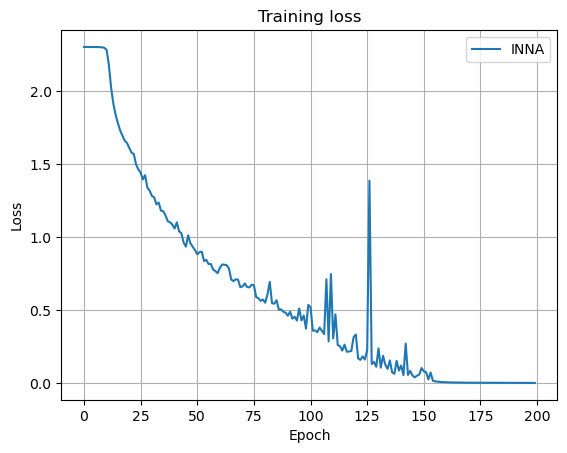

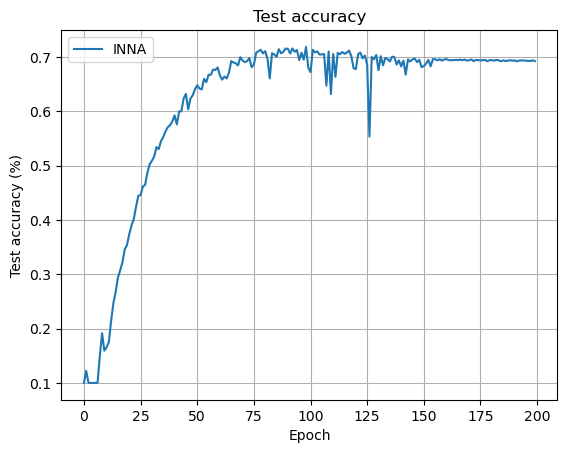

In [6]:
trainloader, testloader = get_cifar10_loaders(batch_size=32)

# ---------- 1) quick grid-search over lr0 (γ0) ----------
best_lr0 = None
best_acc = -1.0

for lr0 in [0.01, 0.05, 0.1, 0.5]:
    print(f"\n=== Trying lr0 = {lr0} ===")
    model_tmp, hist_tmp = train_model(
        mode="inna",
        num_epochs=15,        # like the paper's tuning phase
        trainloader=trainloader,
        testloader=testloader,
        device=device,
        lr0=lr0,
        alpha=0.5,
        beta=0.1,
    )
    final_acc = hist_tmp["test_acc"][-1]
    print(f"Final test_acc after 15 epochs with lr0={lr0}: {final_acc:.4f}")

    if final_acc > best_acc:
        best_acc = final_acc
        best_lr0 = lr0

print(f"\n>>> Best lr0 found: {best_lr0} with test_acc={best_acc:.4f}")

# INNA run
inna_model, inna_hist = train_model(
    mode="inna",
    num_epochs=200,
    trainloader=trainloader,
    testloader=testloader,
    device=device,
    lr0=best_lr0,
    alpha=0.5,
    beta=0.1,
)


# Plots: loss
plt.figure()
plt.plot(inna_hist["loss"], label="INNA")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training loss")
plt.legend()
plt.grid(True)

# Plots: test accuracy
plt.figure()
plt.plot(inna_hist["test_acc"], label="INNA")
plt.ylabel("Test accuracy (fraction)")
plt.xlabel("Epoch")
plt.ylabel("Test accuracy (%)")
plt.title("Test accuracy")
plt.legend()
plt.grid(True)

plt.show()


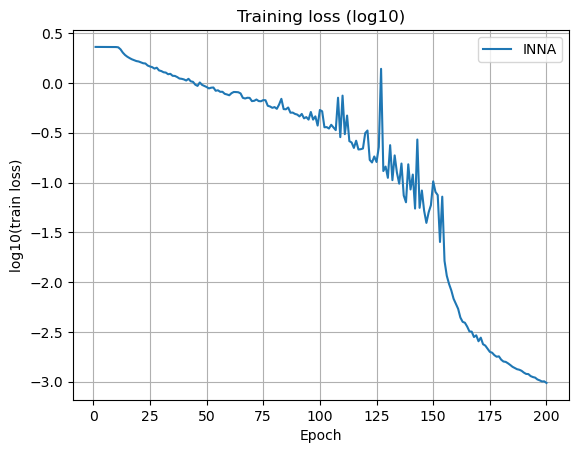

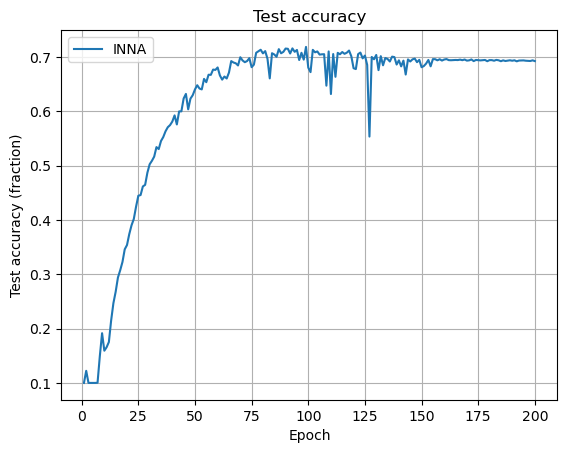

In [9]:
import numpy as np
import matplotlib.pyplot as plt

epochs = np.arange(1, len(inna_hist["loss"]) + 1)

# 1) Training loss (log10), like the paper
plt.figure()
plt.plot(epochs, np.log10(inna_hist["loss"]), label="INNA")
plt.xlabel("Epoch")
plt.ylabel("log10(train loss)")
plt.title("Training loss (log10)")
plt.legend()
plt.grid(True)

# 2) Test accuracy
plt.figure()
plt.plot(epochs, inna_hist["test_acc"], label="INNA")
plt.xlabel("Epoch")
plt.ylabel("Test accuracy (fraction)")  # or "(%)" if you multiply by 100
plt.title("Test accuracy")
plt.legend()
plt.grid(True)

plt.show()


# SINA

In [71]:
# Zang Smoothing
def zang_plus(t, eps):
    """Zang smoothing of ReLU used in SINA."""
    if eps is None or eps <= 0.0:
        return F.relu(t)

    eps_t = t.new_tensor(eps)
    half = 0.5 * eps_t

    # Regions:
    # t > eps/2          -> t
    # -eps/2 <= t <= eps/2 -> (1/(2eps)) * (t + eps/2)^2
    # t < -eps/2         -> 0
    gt = t >  half
    lt = t < -half
    mid = (~gt) & (~lt)

    out = torch.zeros_like(t)
    out[gt] = t[gt]
    out[mid] = 0.5 / eps_t * (t[mid] + half) ** 2
    # out[lt] stays 0
    return out


In [72]:
#Algorithm 4.2
def init_sina_state_fixed(model, gamma0, alpha, beta, eps_fixed, decaypower=0.5):
    """
    gamma_k = gamma0 / (k+1)^decaypower
    eps_fixed is used in the Zang activation and never changed.
    """
    params = [p for p in model.parameters() if p.requires_grad]
    phi = [torch.zeros_like(p) for p in params]

    return {
        "params": params,
        "phi": phi,
        "gamma0": gamma0,
        "alpha": alpha,
        "beta": beta,
        "eps": eps_fixed,
        "step": 0,            # counts iterations
        "decaypower": decaypower,
    }


In [73]:
# (22)-(23)
# def sina_step_fixed(model, sina_state, inputs, labels):
#     params     = sina_state["params"]
#     phi        = sina_state["phi"]
#     alpha      = sina_state["alpha"]
#     beta       = sina_state["beta"]
#     eps        = sina_state["eps"]          # fixed
#     step       = sina_state["step"]
#     gamma0     = sina_state["gamma0"]
#     decaypower = sina_state["decaypower"]

#     # step counter & step size
#     sina_state["step"] = step + 1
#     gamma_k = gamma0 / ((step + 1) ** decaypower)

#     # zero grads
#     for p in params:
#         if p.grad is not None:
#             p.grad.zero_()

#     # forward with smoothed activation
#     outputs = model(inputs, eps=eps)
#     loss = criterion(outputs, labels)
#     loss.backward()

#     # inertial Newton-type update
#     with torch.no_grad():
#         for p, ph in zip(params, phi):
#             if p.grad is None:
#                 continue
#             g = p.grad
#             ph.add_(-gamma_k * g)                        # phi_{k+1} = phi_k - gamma_k g_k
#             p.add_(gamma_k * (-alpha * p + ph - beta * g))  # theta_{k+1}

#     return loss.item(), gamma_k

def sina_step_adaptive_from_model(model, sina_state, inputs, labels, use_inertia=True):
    alpha      = sina_state["alpha"]
    beta       = sina_state["beta"]
    gamma0     = sina_state["gamma0"]
    decaypower = sina_state["decaypower"]
    delta      = sina_state["delta"]
    sigma      = sina_state["sigma"]
    eps        = sina_state["eps"]     # current epsilon
    step       = sina_state["step"]

    # γ_k = γ0 / (k+1)^q
    step += 1
    sina_state["step"] = step
    gamma_k = gamma0 / (step ** decaypower) if decaypower > 0.0 else gamma0

    # usual forward/backward with current eps
    model.train()
    model.zero_grad()
    outputs = model(inputs, eps=eps)    # smoothed activation
    loss = criterion(outputs, labels)
    loss.backward()

    # ---- NEW: gradient norm + ε update ----
    total_norm_sq = 0.0
    for p in model.parameters():
        if p.grad is not None:
            total_norm_sq += p.grad.detach().pow(2).sum().item()
    grad_norm = total_norm_sq ** 0.5

    min_eps = sina_state.get("min_eps", 1e-4)
    if grad_norm < delta * eps:
        eps = max(min_eps, eps * sigma) # shrink epsilon
        sina_state["eps"] = eps         # store back in state
    
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)


    # ---- parameter update (same as before) ----
    phi_list = sina_state["phi"]
    with torch.no_grad():
        if not use_inertia:
            # plain SGD in the smoothed network
            for p in model.parameters():
                if not p.requires_grad or p.grad is None:
                    continue
                p.add_(-gamma_k * p.grad)
        else:
            # full SINA update (22)-(23)
            phi_iter = iter(phi_list)
            for p in model.parameters():
                if not p.requires_grad:
                    continue
                g = p.grad
                if g is None:
                    continue
                ph = next(phi_iter)
                ph.add_(-gamma_k * g)                    # φ_{k+1}
                p.add_(gamma_k * (-alpha * p + ph - beta * g))  # θ_{k+1}

    # you can return eps too if you want to log it
    return loss.item(), gamma_k, eps




In [74]:
def init_sina_state_from_model(
    model,
    alpha=0.5,
    beta=0.1,
    gamma0=0.1,
    eps0=0.1,      # initial epsilon
    decaypower=0.5,
    delta=0.1,     # threshold for shrinking eps
    sigma=0.9,     # eps_{k+1} = sigma * eps_k
):
    phi = []
    for p in model.parameters():
        if p.requires_grad:
            phi.append(torch.zeros_like(p))

    return {
        "phi": phi,
        "alpha": alpha,
        "beta": beta,
        "gamma0": gamma0,
        "eps": eps0,          # <-- now this will change over time
        "decaypower": decaypower,
        "delta": delta,
        "sigma": sigma,
        "step": 0,
    }



In [75]:
class NiNNetSINA(nn.Module):
    def __init__(self, num_classes=10):
        super(NiNNetSINA, self).__init__()

        # Block 1: 3 -> 192
        self.conv1 = nn.Conv2d(3, 192, kernel_size=5, padding=2)
        self.cccp1 = nn.Conv2d(192, 160, kernel_size=1)
        self.cccp2 = nn.Conv2d(160, 96, kernel_size=1)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Block 2: 96 -> 192
        self.conv2 = nn.Conv2d(96, 192, kernel_size=5, padding=2)
        self.cccp3 = nn.Conv2d(192, 192, kernel_size=1)
        self.cccp4 = nn.Conv2d(192, 192, kernel_size=1)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Block 3: 192 -> 192 -> num_classes
        self.conv3 = nn.Conv2d(192, 192, kernel_size=3, padding=1)
        self.cccp5 = nn.Conv2d(192, 192, kernel_size=1)
        self.cccp6 = nn.Conv2d(192, num_classes, kernel_size=1)

        self.pool3 = nn.AvgPool2d(kernel_size=8, stride=1)

    def forward(self, x, eps=None):
        # choose activation
        if eps is None or eps <= 0.0:
            act = F.relu
        else:
            act = lambda z: zang_plus(z, eps)

        # Block 1
        x = act(self.conv1(x))
        x = act(self.cccp1(x))
        x = act(self.cccp2(x))
        x = self.pool1(x)

        # Block 2
        x = act(self.conv2(x))
        x = act(self.cccp3(x))
        x = act(self.cccp4(x))
        x = self.pool2(x)

        # Block 3
        x = act(self.conv3(x))
        x = act(self.cccp5(x))
        x = self.cccp6(x)    # logits, no activation

        x = self.pool3(x)
        x = x.view(x.size(0), -1)
        return x


In [76]:
# def sina_train_model(
#     mode,          # "inna" or "sina"
#     num_epochs,
#     trainloader,
#     testloader,
#     device,
#     lr0=0.1,
#     alpha=0.5,
#     beta=0.1,
#     sina_gamma0=0.1,
#     sina_eps_fixed=0.1,
#     sina_decaypower=0.5,
# ):
#     model = NiNNetSINA(num_classes=10).to(device)

#     if mode == "inna":
#         optimizer = make_inna_optimizer(model, lr0, alpha, beta)  # your existing INNA
#         sina_state = None
#     elif mode == "sina":
#         optimizer = None
#         sina_state = init_sina_state_fixed(
#             model,
#             gamma0=sina_gamma0,
#             alpha=alpha,
#             beta=beta,
#             eps_fixed=sina_eps_fixed,
#             decaypower=sina_decaypower,
#         )
#     else:
#         raise ValueError("mode must be 'inna' or 'sina'")

#     hist_loss, hist_train_acc, hist_test_acc = [], [], []

#     for epoch in range(num_epochs):
#         # ---- one epoch of training ----
#         for x, y in trainloader:
#             x, y = x.to(device), y.to(device)

#             if mode == "inna":
#                 _ = inna_step(model, optimizer, x, y)
#             else:  # "sina"  — DEBUG: smoothed net + plain SGD
#                 _, gamma_k = sina_step_debug_sgd(model, sina_state, x, y)

#         # ---- epoch-end metrics ----
#         eps_for_eval = None if mode == "inna" else sina_state["eps"]
#         train_loss, train_acc = evaluate_loss_acc(model, trainloader, device, eps=eps_for_eval)
#         test_loss,  test_acc  = evaluate_loss_acc(model, testloader,  device, eps=eps_for_eval)

#         hist_loss.append(train_loss)
#         hist_train_acc.append(train_acc)
#         hist_test_acc.append(test_acc)

#         if mode == "inna":
#             print(f"[INNA][Epoch {epoch+1}/{num_epochs}] "
#                   f"train_loss={train_loss:.4f} "
#                   f"train_acc={train_acc:.4f} "
#                   f"test_loss={test_loss:.4f} "
#                   f"test_acc={test_acc:.4f}")
#         else:
#             print(f"[SINA-fixed-eps][Epoch {epoch+1}/{num_epochs}] "
#                   f"train_loss={train_loss:.4f} "
#                   f"train_acc={train_acc:.4f} "
#                   f"test_loss={test_loss:.4f} "
#                   f"test_acc={test_acc:.4f} "
#                   f"gamma={gamma_k:.4e} eps={sina_state['eps']:.4f}")

#     return model, {
#         "loss": hist_loss,
#         "train_acc": hist_train_acc,
#         "test_acc": hist_test_acc,
#     }

# def sina_train_fixed_eps(
#     num_epochs,
#     trainloader,
#     testloader,
#     device,
#     alpha=0.5,
#     beta=0.1,
#     gamma0=0.1,
#     eps_fixed=0.1,
#     decaypower=0.0,   # start with constant γ_k
# ):
#     model = NiNNetSINA(num_classes=10).to(device)
#     sina_state = init_sina_state_from_model(
#         model,
#         alpha=alpha,
#         beta=beta,
#         gamma0=gamma0,
#         eps_fixed=eps_fixed,
#         decaypower=decaypower,
#     )

#     hist_loss, hist_train_acc, hist_test_acc = [], [], []

#     for epoch in range(num_epochs):
#         total_loss, total = 0.0, 0

#         for inputs, labels in trainloader:
#             inputs, labels = inputs.to(device), labels.to(device)
#             loss_val, gamma_k = sina_step_fixed_from_model(model, sina_state, inputs, labels, use_inertia=True)
#             b = labels.size(0)
#             total_loss += loss_val * b
#             total += b

#         train_loss = total_loss / total

#         # evaluate with the same (fixed) eps
#         train_loss_eval, train_acc = evaluate_loss_acc(
#             model, trainloader, device, eps=eps_fixed
#         )
#         test_loss_eval, test_acc = evaluate_loss_acc(
#             model, testloader, device, eps=eps_fixed
#         )

#         hist_loss.append(train_loss_eval)
#         hist_train_acc.append(train_acc)
#         hist_test_acc.append(test_acc)

#         print(f"[SINA-fixed-eps][Epoch {epoch+1}/{num_epochs}] "
#               f"train_loss={train_loss_eval:.4f} "
#               f"train_acc={train_acc:.4f} "
#               f"test_loss={test_loss_eval:.4f} "
#               f"test_acc={test_acc:.4f} "
#               f"gamma={gamma_k:.3e} eps={sina_state['eps']:.3f}")

#     return model, {
#         "loss": hist_loss,
#         "train_acc": hist_train_acc,
#         "test_acc": hist_test_acc,
#     }
def sina_train_adaptive_eps(
    num_epochs,
    trainloader,
    testloader,
    device,
    alpha=0.5,
    beta=0.1,
    gamma0=0.1,
    eps0=0.1,
    decaypower=0.5,
    delta=0.1,
    sigma=0.9,
    use_inertia=True,
):
    model = NiNNetSINA(num_classes=10).to(device)
    sina_state = init_sina_state_from_model(
        model,
        alpha=alpha,
        beta=beta,
        gamma0=gamma0,
        eps0=eps0,
        decaypower=decaypower,
        delta=delta,
        sigma=sigma,
    )

    hist_loss, hist_train_acc, hist_test_acc, hist_eps = [], [], [], []

    for epoch in range(num_epochs):
        total_loss, total = 0.0, 0

        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            loss_val, gamma_k, eps_k = sina_step_adaptive_from_model(
                model, sina_state, inputs, labels, use_inertia=use_inertia
            )
            if not np.isfinite(loss_val):
                print("NaN or inf loss detected, aborting this trial.")
                return model, {
                    "loss": [np.nan],
                    "train_acc": [0.0],
                    "test_acc": [0.0],
                }
            b = labels.size(0)
            total_loss += loss_val * b
            total += b

        train_loss = total_loss / total

        # always use the current ε from state for evaluation
        current_eps = sina_state["eps"]
        train_loss_eval, train_acc = evaluate_loss_acc(
            model, trainloader, device, eps=current_eps
        )
        test_loss_eval, test_acc = evaluate_loss_acc(
            model, testloader, device, eps=current_eps
        )

        hist_loss.append(train_loss_eval)
        hist_train_acc.append(train_acc)
        hist_test_acc.append(test_acc)
        hist_eps.append(current_eps)

        print(f"[SINA-adaptive-eps][Epoch {epoch+1}/{num_epochs}] "
              f"train_loss={train_loss_eval:.4f} "
              f"train_acc={train_acc:.4f} "
              f"test_loss={test_loss_eval:.4f} "
              f"test_acc={test_acc:.4f} "
              f"gamma={gamma_k:.3e} eps={current_eps:.4f}")

    return model, {
        "loss": hist_loss,
        "train_acc": hist_train_acc,
        "test_acc": hist_test_acc,
        "eps": hist_eps,
    }



In [77]:
def run_sina_config(
    trainloader,
    testloader,
    device,
    num_epochs,
    alpha,
    beta,
    gamma0,
    eps0,
    decaypower,
    delta,
    sigma,
    use_inertia=True,
):
    model, hist = sina_train_adaptive_eps(
        num_epochs=num_epochs,
        trainloader=trainloader,
        testloader=testloader,
        device=device,
        alpha=alpha,
        beta=beta,
        gamma0=gamma0,
        eps0=eps0,
        decaypower=decaypower,
        delta=delta,
        sigma=sigma,
        use_inertia=use_inertia,
    )
    # take last test acc as score
    final_test_acc = hist["test_acc"][-1]
    return final_test_acc, hist


In [78]:
import numpy as np
import random
import torch

def sample_hparams():
    # ranges you can tweak
    alpha   = 10 ** np.random.uniform(-4, -2)   # 1e-4 ... 1e-2
    beta    = 10 ** np.random.uniform(-4, -2)   # 1e-4 ... 1e-2
    gamma0  = 10 ** np.random.uniform(-3, -1.7) # 1e-3 ... ~0.02
    eps0    = 10 ** np.random.uniform(-2, -0.3) # 1e-2 ... ~0.5
    decay   = np.random.choice([0.3, 0.5])      # avoid 0.0 for now
    delta   = np.random.uniform(0.05, 0.3)
    sigma   = np.random.uniform(0.7, 0.99)

    return dict(
        alpha=alpha,
        beta=beta,
        gamma0=gamma0,
        eps0=eps0,
        decaypower=decay,
        delta=delta,
        sigma=sigma,
    )


In [79]:
# prepare data once
trainloader, testloader = get_cifar10_loaders(batch_size=32)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_trials = 20        # how many random configs to try
short_epochs = 10      # small budget for tuning

best_acc = 0.0
best_cfg = None

for trial in range(1, num_trials + 1):
    # optional: fix seed per trial for reproducibility
    torch.manual_seed(trial)
    np.random.seed(trial)
    random.seed(trial)

    cfg = sample_hparams()
    print(f"\n=== Trial {trial}/{num_trials} ===")
    print("Config:", cfg)

    acc, hist = run_sina_config(
        trainloader=trainloader,
        testloader=testloader,
        device=device,
        num_epochs=short_epochs,
        alpha=cfg["alpha"],
        beta=cfg["beta"],
        gamma0=cfg["gamma0"],
        eps0=cfg["eps0"],
        decaypower=cfg["decaypower"],
        delta=cfg["delta"],
        sigma=cfg["sigma"],
        use_inertia=True,
    )

    print(f"  -> final test_acc after {short_epochs} epochs: {acc:.4f}")

    if acc > best_acc:
        best_acc = acc
        best_cfg = cfg
        print(f"  *** new best! test_acc={best_acc:.4f}")

print("\nBest config found:")
print(best_cfg)
print("Best short-run test_acc:", best_acc)

# re-train with more epochs using best_cfg
long_epochs = 200
best_model, best_hist = sina_train_adaptive_eps(
    num_epochs=long_epochs,
    trainloader=trainloader,
    testloader=testloader,
    device=device,
    alpha=best_cfg["alpha"],
    beta=best_cfg["beta"],
    gamma0=best_cfg["gamma0"],
    eps0=best_cfg["eps0"],
    decaypower=best_cfg["decaypower"],
    delta=best_cfg["delta"],
    sigma=best_cfg["sigma"],
    use_inertia=True,
)



Files already downloaded and verified
Files already downloaded and verified

=== Trial 1/20 ===
Config: {'alpha': 0.0006824078427098834, 'beta': 0.002758347554916672, 'gamma0': 0.0010003424236878732, 'eps0': 0.03265617941919259, 'decaypower': np.float64(0.5), 'delta': 0.10902224423799402, 'sigma': 0.8150084109158475}
[SINA-adaptive-eps][Epoch 1/10] train_loss=2.3035 train_acc=0.1000 test_loss=2.3035 test_acc=0.1000 gamma=2.530e-05 eps=0.0327
[SINA-adaptive-eps][Epoch 2/10] train_loss=2.3035 train_acc=0.1000 test_loss=2.3035 test_acc=0.1000 gamma=1.789e-05 eps=0.0327
[SINA-adaptive-eps][Epoch 3/10] train_loss=2.3035 train_acc=0.1000 test_loss=2.3035 test_acc=0.1000 gamma=1.461e-05 eps=0.0327
[SINA-adaptive-eps][Epoch 4/10] train_loss=2.3035 train_acc=0.1000 test_loss=2.3035 test_acc=0.1000 gamma=1.265e-05 eps=0.0327
[SINA-adaptive-eps][Epoch 5/10] train_loss=2.3035 train_acc=0.1000 test_loss=2.3035 test_acc=0.1000 gamma=1.132e-05 eps=0.0327
[SINA-adaptive-eps][Epoch 6/10] train_loss=2.3